# Importing Libraries

In [1]:
# table manipulation, calculating
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100) # increase the maximum number of columns

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# learning
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold

import lightgbm as lgb
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

# Ignore all warnings
import warnings
warnings.simplefilter("ignore")

# Importing datasets

In [2]:
df_train = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')

In [3]:
df_train

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,22.1,1
2186,2186,362,1012.4,17.2,17.3,16.3,15.3,91.0,88.0,0.0,50.0,35.3,1
2187,2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,32.9,1
2188,2188,364,1022.3,16.4,15.2,13.8,14.7,92.0,93.0,0.1,40.0,18.0,1


In [4]:
df_test

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4
...,...,...,...,...,...,...,...,...,...,...,...,...
725,2915,361,1020.8,18.2,17.6,16.1,13.7,96.0,95.0,0.0,20.0,34.3
726,2916,362,1011.7,23.2,18.1,16.0,16.0,78.0,80.0,1.6,40.0,25.2
727,2917,363,1022.7,21.0,18.5,17.0,15.5,92.0,96.0,0.0,50.0,21.9
728,2918,364,1014.4,21.0,20.0,19.7,19.8,94.0,93.0,0.0,50.0,39.5


# EDA

## detail : https://www.kaggle.com/code/leonchani/eda-inspection-for-binary-prediction-with-rainfall/notebook#competiton-:-Binary-Prediction-with-a-Rainfall-Dataset

In [5]:
# I want to do stacking. What I want to do is to create explanatory variables to create a pseudo-target variable.
# This time I just want to stack, so I'm not too concerned about accuracy.
# Check the percentage.
df_train['rainfall'].value_counts(normalize=True).reset_index()

,rainfall,proportion
0,1,0.753425
1,0,0.246575


In [6]:
# Evaluate the values ​​in the 'cloud' column and flag them
# display(df_train['cloud'].apply(lambda x: 1 if x > 65 else 0).value_counts(normalize=True).reset_index())
# df_train['cloud_flg'] = df_train['cloud'].apply(lambda x: 1 if x > 65 else 0)

# display(pd.crosstab(df_train['rainfall'], df_train['cloud_test'], margins=True))
# display(pd.crosstab(df_train['rainfall'], df_train['cloud_test'], margins=True,normalize='all'))

# grouped_size = df_train.groupby(['rainfall', 'cloud_flg'], as_index = False, dropna = False).size().sort_values(by = 'size', ascending = False)
# grouped_size['cumulative_percentage'] = grouped_size['size'].cumsum() / grouped_size['size'].sum()
# grouped_size

# Evaluate the value of the 'sunshine' column and flag it
# display(df_train['sunshine'].apply(lambda x: 1 if x <= 6.5 else 0).value_counts(normalize=True).reset_index())
# df_train['sunshine_test'] = df_train['sunshine'].apply(lambda x: 1 if x <= 6.5 else 0)

# display(pd.crosstab(df_train['rainfall'], df_train['sunshine_test'], margins=True))
# display(pd.crosstab(df_train['rainfall'], df_train['sunshine_test'], margins=True,normalize='all'))

# grouped_size = df_train.groupby(['cloud_test', 'sunshine_test'], as_index = False, dropna = False).size().sort_values(by = 'size', ascending = False)
# grouped_size['cumulative_percentage'] = grouped_size['size'].cumsum() / grouped_size['size'].sum()
# grouped_size

# Preprocessing

In [7]:
## KNN - Handling missing values
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
df_test["winddirection"] = imputer.fit_transform(df_test[["winddirection"]])

# Feature Engineering

In [8]:
def generate_features(df):

    # time_series
    ## lag feature
    # for lag in [1, 3, 7, 14, 30]:
    #     df[f'cloud_lag_{lag}'] = df['cloud'].shift(lag)
    #     df[f'sunshine_lag_{lag}'] = df['sunshine'].shift(lag)
    #     df[f'humidity_lag_{lag}'] = df['humidity'].shift(lag)

    # ## amount of change
    # df['cloud_change_1d'] = df['cloud'] - df['cloud'].shift(1)
    # df['sunshine_change_1d'] = df['sunshine'] - df['sunshine'].shift(1)
    # df['humidity_change_1d'] = df['humidity'] - df['humidity'].shift(1)

    # rate
    # df['rate_maxtemp_temparature'] = df['maxtemp'] / df['temparature']
    # df['rate_mintemp_temparature'] = df['mintemp'] / df['temparature']
    # df['rate_maxtemp_mintemp_temparature'] = (df['maxtemp'] - df['mintemp']) / df['temparature']

    # df['rate_maxtemp_mintemp_cloud'] = (df['maxtemp'] - df['mintemp']) * df['cloud']
    # df['rate_maxtemp_mintemp_sunshine'] = (df['maxtemp'] - df['mintemp']) * df['sunshine']
    # df['rate_maxtemp_mintemp_humidity'] = (df['maxtemp'] - df['mintemp']) * df['humidity']

    # df['rate_maxtemp_mintemp_temparature_cloud'] = ((df['maxtemp'] - df['mintemp']) / df['temparature']) * df['cloud']
    # df['rate_maxtemp_mintemp_temparature_sunshine'] = ((df['maxtemp'] - df['mintemp']) / df['temparature']) * df['sunshine']
    # df['rate_maxtemp_mintemp_temparature_humidity'] = ((df['maxtemp'] - df['mintemp']) / df['temparature']) * df['humidity']
    
    # interaction
    ## cloud
    # df['interaction_cloud_temperature'] = df['cloud'] * df['temparature']
    # df['interaction_cloud_mintemp'] = df['cloud'] * df['mintemp']
    # df['interaction_cloud_winddirection'] = df['cloud'] * df['winddirection']

    # df['interaction_cloud_windspeed_sqrt'] = np.sqrt(df['cloud'] * df['windspeed'])
    # df['interaction_cloud_temperature_sqrt'] = np.sqrt(df['cloud'] * df['temparature'])
    # df['interaction_cloud_mintemp_sqrt'] = np.sqrt(df['cloud'] * df['mintemp'])
    # df['interaction_cloud_winddirection_sqrt'] = np.sqrt(df['cloud'] * df['winddirection'])

    # df['interaction_cloud_temperature_log'] = np.log(df['cloud'] * df['temparature'])
    # df['interaction_cloud_mintemp_log'] = np.log(df['cloud'] * df['mintemp'])
    # df['interaction_cloud_winddirection_log'] = np.log(df['cloud'] * df['winddirection'])

    ## sunshine
    # df['interaction_sunshine_temperature'] = df['sunshine'] * df['temparature']
    # df['interaction_sunshine_mintemp'] = df['sunshine'] * df['mintemp']
    # df['interaction_sunshine_winddirection'] = df['sunshine'] * df['winddirection']

    df['interaction_sunshine_windspeed_sqrt'] = np.sqrt(df['sunshine'] * df['windspeed'])
    df['interaction_sunshine_temperature_sqrt'] = np.sqrt(df['sunshine'] * df['temparature'])
    df['interaction_sunshine_mintemp_sqrt'] = np.sqrt(df['sunshine'] * df['mintemp'])
    df['interaction_sunshine_winddirection_sqrt'] = np.sqrt(df['sunshine'] * df['winddirection'])

    # df['interaction_sunshine_temperature_log'] = np.log(df['sunshine'] * df['temparature'])
    # df['interaction_sunshine_mintemp_log'] = np.log(df['sunshine'] * df['mintemp'])
    # df['interaction_sunshine_winddirection_log'] = np.log(df['sunshine'] * df['winddirection'])
    
    ## humidity
    # df['interaction_humidity_temperature'] = df['humidity'] * df['temparature']
    # df['interaction_humidity_mintemp'] = df['humidity'] * df['mintemp']
    # df['interaction_humidity_winddirection'] = df['humidity'] * df['winddirection']

    df['interaction_humidity_windspeed_sqrt'] = np.sqrt(df['humidity'] * df['windspeed'])
    df['interaction_humidity_temperature_sqrt'] = np.sqrt(df['humidity'] * df['temparature'])
    df['interaction_humidity_mintemp_sqrt'] = np.sqrt(df['humidity'] * df['mintemp'])
    df['interaction_humidity_winddirection_sqrt'] = np.sqrt(df['humidity'] * df['winddirection'])

    # df['interaction_humidity_temperature_log'] = np.log(df['humidity'] * df['temparature'])
    # df['interaction_humidity_mintemp_log'] = np.log(df['humidity'] * df['mintemp'])
    # df['interaction_humidity_winddirection_log'] = np.log(df['humidity'] * df['winddirection'])

    # # univariable
    # ## A function that defines wind direction
    # def get_wind_direction(degree):
    #     if 337.5 <= degree or degree < 22.5:
    #         return 1  # 'N'
    #     elif 22.5 <= degree < 67.5:
    #         return 2 # 'NE'
    #     elif 67.5 <= degree < 112.5:
    #         return 3 # 'E'
    #     elif 112.5 <= degree < 157.5:
    #         return 4 # 'SE'
    #     elif 157.5 <= degree < 202.5:
    #         return 5 # 'S'
    #     elif 202.5 <= degree < 247.5:
    #         return 6 # 'SW'
    #     elif 247.5 <= degree < 292.5:
    #         return 7 # 'W'
    #     else:
    #         return 8 # 'NW'
            
    # df['winddirection_flg'] = df['winddirection'].apply(get_wind_direction)
    # winddirection_dummies = pd.get_dummies(df['winddirection_flag'], prefix='winddirection').astype(int)
    # df = pd.concat([df, winddirection_dummies], axis=1)

    # df_grp_winddirection_flg_cloud = df.groupby(['winddirection_flg'], as_index = False, dropna = False)['cloud'].mean().rename(columns={'cloud': 'mean_cloud'})
    # df_grp_winddirection_flg_sunshine = df.groupby(['winddirection_flg'], as_index = False, dropna = False)['sunshine'].mean().rename(columns={'sunshine': 'mean_sunshine'})
    # df_grp_winddirection_flg_humidity = df.groupby(['winddirection_flg'], as_index = False, dropna = False)['humidity'].mean().rename(columns={'humidity': 'mean_humidity'})
    # df_grp_winddirection_flg_temparature = df.groupby(['winddirection_flg'], as_index = False, dropna = False)['temparature'].mean().rename(columns={'temparature': 'mean_temparature'})
    # df_grp_winddirection_flg_mintemp = df.groupby(['winddirection_flg'], as_index = False, dropna = False)['mintemp'].mean().rename(columns={'mintemp': 'mean_mintemp'})

    # df = pd.merge(df, df_grp_winddirection_flg_cloud, on = 'winddirection_flg', how = 'inner')
    # df = pd.merge(df, df_grp_winddirection_flg_sunshine, on = 'winddirection_flg', how = 'inner')
    # df = pd.merge(df, df_grp_winddirection_flg_humidity, on = 'winddirection_flg', how = 'inner')
    # df = pd.merge(df, df_grp_winddirection_flg_temparature, on = 'winddirection_flg', how = 'inner')
    # df = pd.merge(df, df_grp_winddirection_flg_mintemp, on = 'winddirection_flg', how = 'inner') 

    # for stacking
    df['cloud_flg'] = df['cloud'].apply(lambda x: 1 if x > 65 else 0)

    # df['gathing_weather'] = (df['cloud'] * 0.6) + (df['sunshine'] * 0.3) + (df['humidity'] * 0.1)

    del df['cloud']
    # del df['sunshine']
    # del df['humidity']

    # df = df.drop(['winddirection_flg'], axis=1) # 不要な列を削除

    return df

In [9]:
df_train = generate_features(df_train)
df_test = generate_features(df_test)

# Modeling

In [10]:
SEED = 42
NUM_SPLITS = 4 # 10

In [11]:
X = df_train.drop(columns=["rainfall", "cloud_flg"])
y = df_train["cloud_flg"]

# X = df_train.drop(columns=["rainfall"])
# y = df_train["rainfall"]

In [12]:
def get_model():
    from sklearn.ensemble import VotingClassifier
    import lightgbm as lgb
    
    params = {
        'objective': 'binary', # Objective function: binary classification
        'metric': 'auc', # Evaluation metric: AUC (Area Under the Curve)
        'boosting_type': 'gbdt', # Boosting type: Gradient Boosting Decision Tree
        'learning_rate': 0.01, # Learning rate: A smaller rate slows down learning but can improve accuracy
        'num_leaves': 30,  # Number of leaves in a decision tree: Set smaller to prevent overfitting
        'max_depth': 8,    # Maximum depth of a decision tree: Set smaller to prevent overfitting
        'feature_fraction': 0.7, # Fraction of features to sample: 0.7 means 70% of columns are used for learning
        'bagging_fraction': 0.7, # Fraction of data to sample: 0.7 means 70% of data is used for learning
        'bagging_freq': 1, # Frequency to apply bagging_fraction: 1 means apply at each iteration
        'lambda_l1': 0.1, # L1 regularization term weight: Prevents overfitting
        'lambda_l2': 0.1, # L2 regularization term weight: Prevents overfitting
        'min_child_samples': 20, # Minimum number of data needed in a leaf: Too small can cause overfitting
        'min_data_in_leaf': 40, # Minimum number of data needed in a leaf: Too small can cause overfitting
        'min_sum_hessian_in_leaf': 1e-2, # Minimum sum of hessians needed in a leaf: Too small can cause overfitting
        'verbosity': -1, # Level of logging output during learning: -1 means no output
        'early_stopping_rounds': 100, # Number of rounds for early stopping: Learning stops if the score doesn't improve for the specified rounds
        'random_state': SEED, # Random seed: Ensures reproducibility
        'colsample_bytree': 0.7, # Subsample ratio of columns when constructing each tree (prevents overfitting)
        'min_child_weight': 1e-3, # Minimum sum of instance weight (hessian) needed in a child (leaf)
        'path_smooth': 0.1, # Parameter to smooth decision tree path
        'max_bin': 255, # Maximum number of bins to bucket feature values
        'n_estimators': 1000, # Number of boosting iterations (number of trees)
        'scale_pos_weight': 1, # Weight for balancing unbalanced classes
        'min_gain_to_split': 0.1, # Minimum loss reduction required to make a further partition on a leaf node
        #'feature_fraction_bynode': 0.8, # Fraction of features to consider for each node split
        #'force_col_wise': True, # Force column-wise histogram building
        #'extra_trees': True, # Enable random forest like behavior
        #'num_iterations': 2000, # Number of boosting iterations
        'drop_rate': 0.1, # Dropout rate for Dropout Boosting
        'skip_drop': 0.5, # Skip rate for Dropout Boosting
        'top_rate': 0.2, # Ratio of top instances to keep for GOSS
        'other_rate': 0.1, # Ratio of other instances to keep for GOSS
        #'categorical_feature': [0, 1, 2], # Indices of categorical features (add as needed)
    }
    
    lgb_model = lgb.LGBMClassifier(**params)
    
    return lgb_model

In [13]:
cv = KFold(n_splits=NUM_SPLITS, random_state=SEED, shuffle=True)
scores = []
models = []

for fold, (train_index, valid_index) in enumerate(cv.split(X)):
    X_train, X_val = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_val = y.iloc[train_index], y.iloc[valid_index]

    model = get_model()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='auc') #修正された引数

    y_pred_val = model.predict_proba(X_val)[:, 1]

    score = roc_auc_score(y_val, y_pred_val)

    scores.append(score)
    models.append(model)

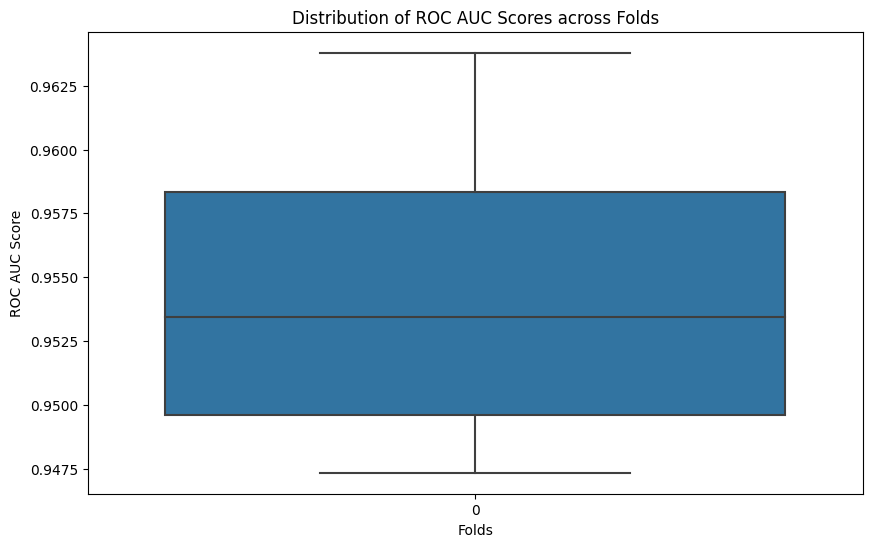

Scores: [0.9564974457215837, 0.9637920298879202, 0.9473415534438074, 0.9503542292829541]


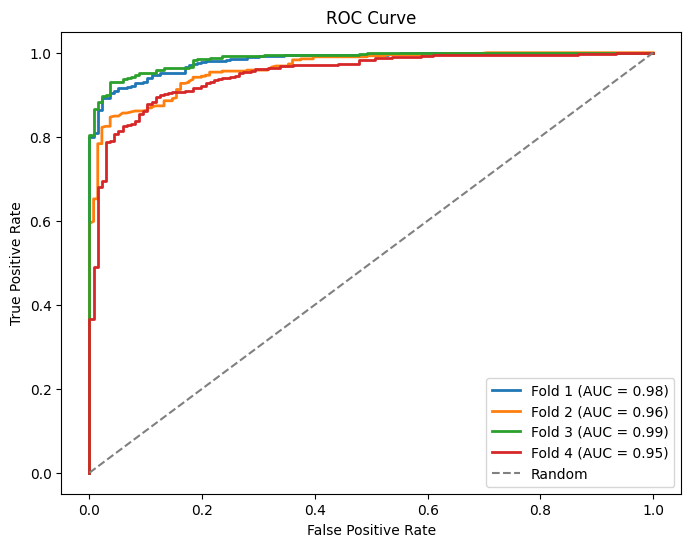

Cross-validated ROC AUC score: 0.95450 +/- 0.00630


In [14]:
# Visualize the scores of each fold with box plots
plt.figure(figsize=(10, 6))
sns.boxplot(data=scores)
plt.title('Distribution of ROC AUC Scores across Folds')
plt.xlabel('Folds')
plt.ylabel('ROC AUC Score')
plt.show()

# Display the scores of each fold in a list
print("Scores:", scores)

# Plot the ROC curve for each fold
plt.figure(figsize=(8, 6))
for fold, model in enumerate(models):
    y_pred_val = model.predict_proba(X.iloc[valid_index])[:, 1]
    fpr, tpr, thresholds = roc_curve(y.iloc[valid_index], y_pred_val)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Fold {fold+1} (AUC = {roc_auc:.2f})')

# diagonal
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')

# Graph settings
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Shows the mean and standard deviation of AUC scores
print(f'Cross-validated ROC AUC score: {np.mean(scores):.5f} +/- {np.std(scores):.5f}') 

In [15]:
def stacking(df_train, df_test, X, y, NUM_SPLITS=5, SEED=42):
    cv = KFold(n_splits=NUM_SPLITS, random_state=SEED, shuffle=True)
    scores = []
    models = []
    oof_train = np.zeros((len(df_train),))
    oof_test = np.zeros((len(df_test),))

    for fold, (train_index, valid_index) in enumerate(cv.split(X, y)):
        X_train, X_val = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_val = y.iloc[train_index], y.iloc[valid_index]

        model = get_model()
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='auc', callbacks=[lgb.early_stopping(100, verbose=False)])

        y_pred_val = model.predict_proba(X_val)[:, 1]
        y_pred_test = model.predict_proba(df_test[X.columns])[:, 1] # df_testの予測

        oof_train[valid_index] = y_pred_val
        oof_test += y_pred_test / NUM_SPLITS

        score = roc_auc_score(y_val, y_pred_val)
        scores.append(score)
        models.append(model)

    df_train['oof_pred'] = oof_train
    df_test['oof_pred'] = oof_test

    print(f"Mean AUC: {np.mean(scores)}")

    return df_train, df_test, models

# Perform stacking
df_train_tmp, df_test_tmp, models = stacking(df_train, df_test, X, y)

Mean AUC: 0.9544200446771139


# Select Features

## feature_importance

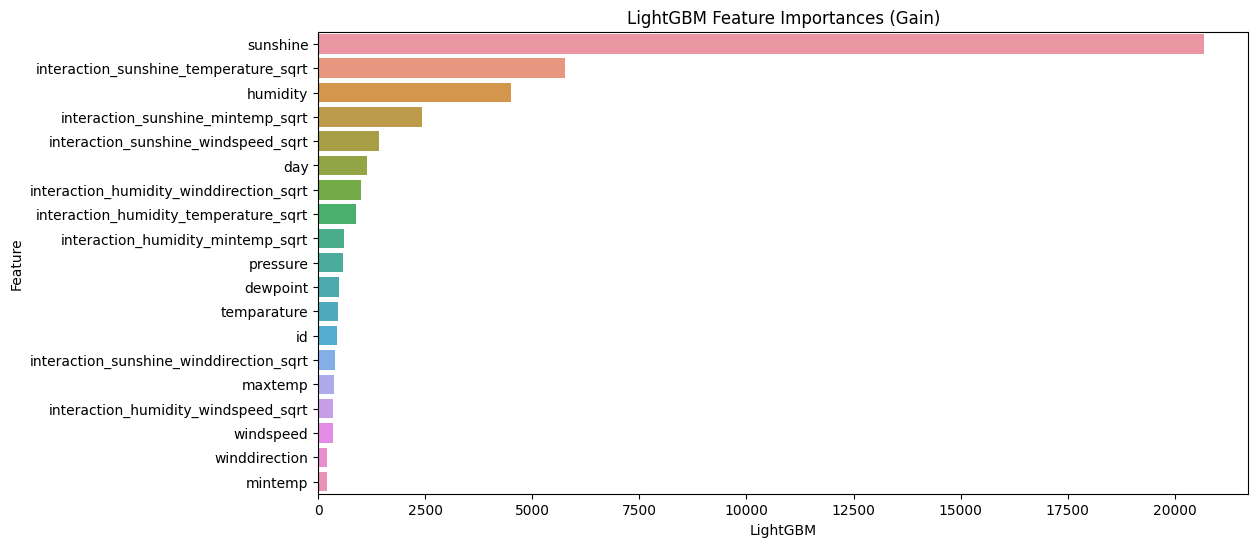

,Feature,LightGBM
8,sunshine,20685.206923
12,interaction_sunshine_temperature_sqrt,5758.498359
7,humidity,4490.614858
13,interaction_sunshine_mintemp_sqrt,2431.782506
11,interaction_sunshine_windspeed_sqrt,1417.876410
1,day,1127.269816
18,interaction_humidity_winddirection_sqrt,994.066449
16,interaction_humidity_temperature_sqrt,882.693757
17,interaction_humidity_mintemp_sqrt,593.678041
2,pressure,587.558777


In [16]:
# Get the importance of each model's features using gain
lgb_importances = model.booster_.feature_importance(importance_type='gain')

# Get the name of the feature
feature_names = X.columns

# Summarize feature importance in a DataFrame
df_decision_tree_importances = pd.DataFrame({
    'Feature': feature_names,
    'LightGBM': lgb_importances,
})

# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='LightGBM', y='Feature', data=df_decision_tree_importances.sort_values(by='LightGBM', ascending=False))
plt.title('LightGBM Feature Importances (Gain)')
plt.show()

display(df_decision_tree_importances.sort_values(by='LightGBM', ascending=False))

## SHAP

In [17]:
import shap

# LGBM SHAP values
explainer_lgb = shap.TreeExplainer(model)
shap_values_lgb = explainer_lgb.shap_values(X)

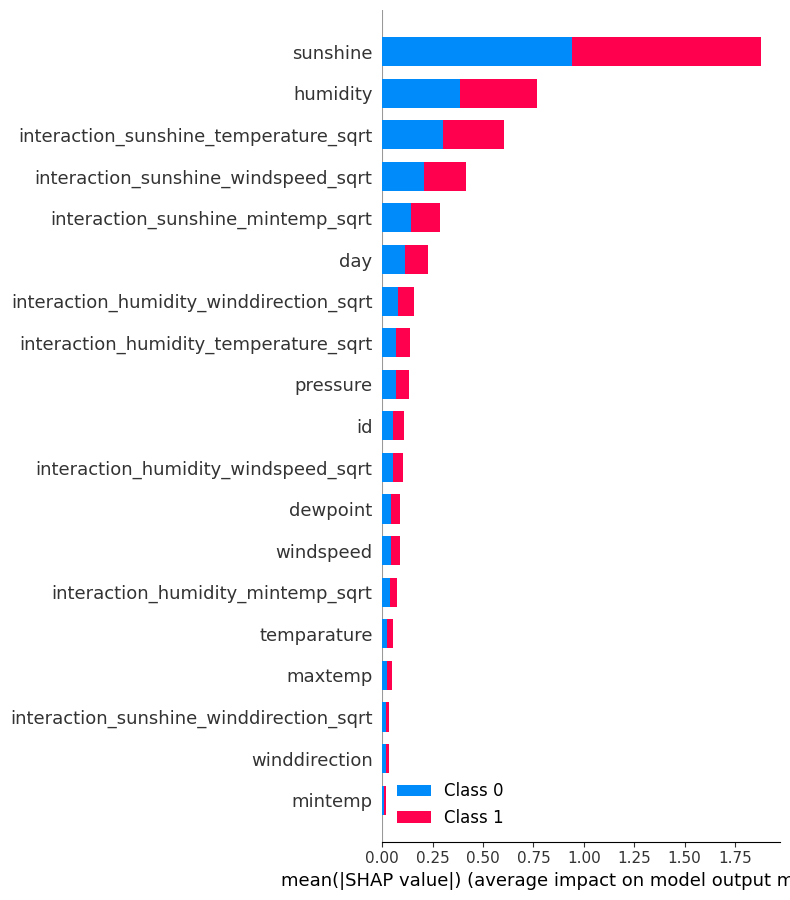

In [18]:
shap.summary_plot(shap_values_lgb, X)

In [19]:
# If shap_values_lgb is a list, convert it to a NumPy array
if isinstance(shap_values_lgb, list):
    shap_values_lgb = np.array(shap_values_lgb)

# Handling the multiclass classification case
if len(shap_values_lgb.shape) == 3:
    shap_importance = np.abs(shap_values_lgb).mean(axis=1).mean(axis=0)
# Handling binary classification cases
else:
    shap_importance = np.abs(shap_values_lgb).mean(axis=0)

# Store in DataFrame
df_shap_importance = pd.DataFrame({
    'feature': X.columns,
    'shap_importance': shap_importance
})

# Sort by importance
df_shap_importance = df_shap_importance.sort_values('shap_importance', ascending=False)
display(df_shap_importance)

,feature,shap_importance
8,sunshine,0.939831
7,humidity,0.385143
12,interaction_sunshine_temperature_sqrt,0.301379
11,interaction_sunshine_windspeed_sqrt,0.208791
13,interaction_sunshine_mintemp_sqrt,0.144268
1,day,0.112615
18,interaction_humidity_winddirection_sqrt,0.077777
16,interaction_humidity_temperature_sqrt,0.068682
2,pressure,0.066659
0,id,0.052946


In [20]:
# If you were to select the features, it would look something like this:
# Select the top 20 features
# selected_features = df_decision_tree_importances.sort_values(by='LightGBM', ascending=False)['Feature'].iloc[:10].tolist()
# selected_features

# Select above of shap_importance greater than or equal to 0.01
# selected_features = df_shap_importance[df_shap_importance["shap_importance"]>=0.01]
# selected_features = selected_features['feature'].tolist()

# Modeling_re

In [21]:
df_train

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,sunshine,winddirection,windspeed,rainfall,interaction_sunshine_windspeed_sqrt,interaction_sunshine_temperature_sqrt,interaction_sunshine_mintemp_sqrt,interaction_sunshine_winddirection_sqrt,interaction_humidity_windspeed_sqrt,interaction_humidity_temperature_sqrt,interaction_humidity_mintemp_sqrt,interaction_humidity_winddirection_sqrt,cloud_flg,oof_pred
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,1.1,60.0,17.2,1,4.349713,4.760252,4.678675,8.124038,38.683330,42.334383,41.608893,72.249567,1,0.899502
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,0.0,50.0,21.9,1,0.000000,0.000000,0.000000,0.000000,45.612498,40.068691,38.742741,68.920244,1,0.990567
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,8.3,70.0,18.1,1,12.256835,11.559844,11.008179,24.103942,36.844267,34.749101,33.090784,72.456884,0,0.260484
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,0.0,60.0,35.6,1,0.000000,0.000000,0.000000,0.000000,58.154965,41.121770,40.068691,75.498344,1,0.800125
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,3.6,40.0,24.8,0,9.448809,8.138796,7.397297,12.000000,35.911001,30.932184,28.114053,45.607017,0,0.600096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,0.1,40.0,22.1,1,1.486607,1.435270,1.382027,2.000000,46.300108,44.701230,43.043002,62.289646,1,0.895296
2186,2186,362,1012.4,17.2,17.3,16.3,15.3,91.0,0.0,50.0,35.3,1,0.000000,0.000000,0.000000,0.000000,56.677156,39.677450,38.513634,67.453688,1,0.895296
2187,2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,5.0,40.0,32.9,1,12.825755,9.027735,8.455767,14.142136,50.981369,35.884537,33.611010,56.213877,1,0.746866
2188,2188,364,1022.3,16.4,15.2,13.8,14.7,92.0,0.1,40.0,18.0,1,1.341641,1.232883,1.174734,2.000000,40.693980,37.395187,35.631447,60.663004,1,0.977231


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data.dataset import random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import random

In [23]:
SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [24]:
X = df_train.drop(columns=["rainfall", "cloud_flg"])
y = df_train["rainfall"]
test = df_test.drop(columns=["cloud_flg"])

In [25]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
test = scaler.transform(test)

In [26]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
test = torch.tensor(test, dtype=torch.float32)
y = y.reshape(-1,1)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

k_folds = 4 # 10
kf = KFold(n_splits=k_folds, shuffle=True, random_state=SEED)

cv_scores = []
models = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f'Fold {fold + 1}/{k_folds}')

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    train_dataset = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
    val_dataset = DataLoader(TensorDataset(X_val, y_val), batch_size=32, shuffle=False)

    model = nn.Sequential(
        nn.Linear(X.shape[1], 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(64, 32),
        nn.BatchNorm1d(32),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(32, 1),
        nn.Sigmoid()
    ).to(device)

    # Optimization algorithm fixes
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # 学習率と重み減衰を調整
    loss_fn = nn.BCELoss().to(device)

    # Training
    num_epochs = 50  # Adjust the number of epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dataset:
            optimizer.zero_grad()
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    y_true, y_pred = [], []
    with torch.no_grad():
        for x_batch, y_batch in val_dataset:
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            val_losses.append(loss.item())
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())

    # scoring
    auc_score = roc_auc_score(y_true, y_pred)
    cv_scores.append(auc_score)
    print(f'Fold {fold + 1} AUC: {auc_score:.4f}')

    models.append(model)

print(f'Cross-validated ROC AUC score: {np.mean(cv_scores):.5f} +/- {np.std(cv_scores):.5f}')

Fold 1/4
Fold 1 AUC: 0.8596
Fold 2/4
Fold 2 AUC: 0.8791
Fold 3/4
Fold 3 AUC: 0.8771
Fold 4/4
Fold 4 AUC: 0.8771
Cross-validated ROC AUC score: 0.87323 +/- 0.00789


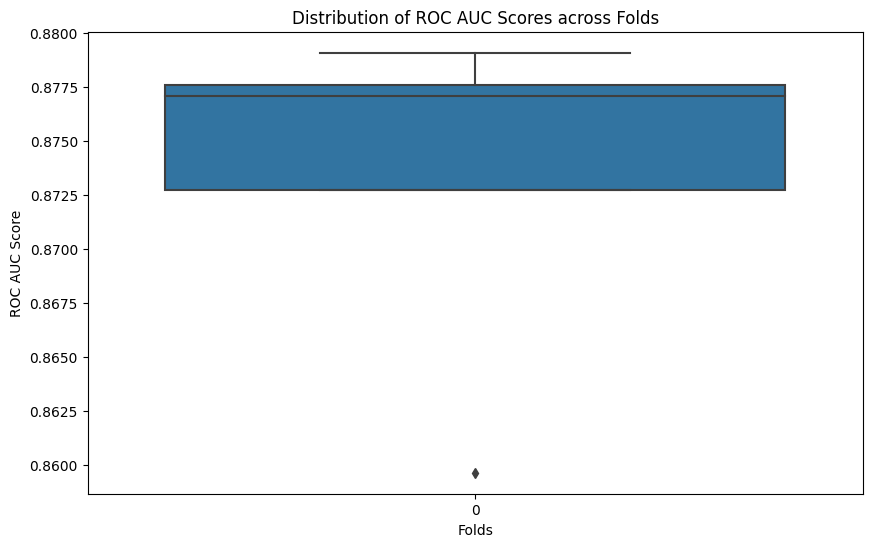

Scores: [0.8596288515406163, 0.8790904987587452, 0.8771102466236054, 0.8770857855016271]


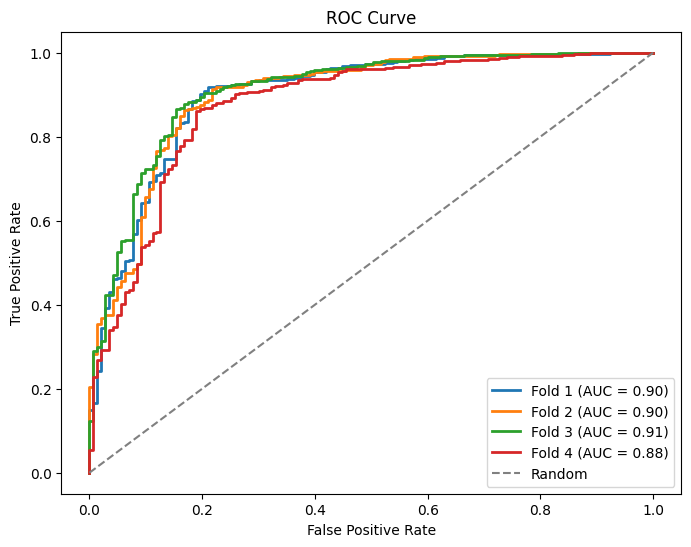

Cross-validated ROC AUC score: 0.87323 +/- 0.00789


In [28]:
# Visualize the scores of each fold with box plots
plt.figure(figsize=(10, 6))
sns.boxplot(data=cv_scores)
plt.title('Distribution of ROC AUC Scores across Folds')
plt.xlabel('Folds')
plt.ylabel('ROC AUC Score')
plt.show()

# Display the scores of each fold in a list
print("Scores:", cv_scores)

# Plot the ROC curve for each fold
plt.figure(figsize=(8, 6))
for fold, model in enumerate(models):
    model.eval()  # Set to evaluation mode
    y_pred_val = []
    y_true_val = []
    with torch.no_grad():
        for x_batch, y_batch in val_dataset:
            pred = model(x_batch)
            y_pred_val.extend(pred.cpu().numpy())
            y_true_val.extend(y_batch.cpu().numpy())
    y_pred_val = np.array(y_pred_val)
    y_true_val = np.array(y_true_val)
    fpr, tpr, thresholds = roc_curve(y_true_val, y_pred_val)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Fold {fold+1} (AUC = {roc_auc:.2f})')

# 対角線
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')

# グラフの設定
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# AUCスコアの平均と標準偏差を表示
print(f'Cross-validated ROC AUC score: {np.mean(cv_scores):.5f} +/- {np.std(cv_scores):.5f}')

# Prediction

In [29]:
test_id = df_test["id"]

In [30]:
submit_score = []

for fold_, model in enumerate(models):
    pred_ = model(test)
    submit_score.append(pred_)

# predict test data
pred = np.mean([score.detach().cpu().numpy() for score in submit_score], axis=0)


# Submission

In [31]:
submission = pd.DataFrame({
    'id': test_id,
    'rainfall': pred.flatten()
})

# Save
submission.to_csv('submission.csv', index=False)

submission

,id,rainfall
0,2190,0.994573
1,2191,0.995030
2,2192,0.962783
3,2193,0.211322
4,2194,0.080961
...,...,...
725,2915,0.979435
726,2916,0.946534
727,2917,0.954746
728,2918,0.995624
